In [1]:
#need to read data from website
!pip install lxml

     |████████████████████████████████| 5.8MB 2.7MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import lxml
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [3]:
# don't know why could not find geopy, so install in advance
!pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

     |████████████████████████████████| 102kB 16.3MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib


In [4]:
data = pd.DataFrame()

In [5]:
#read Singapore district data from web
url = 'https://en.wikipedia.org/wiki/Postal_codes_in_Singapore'
data = pd.read_html(url)[0]
data.head()

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park"
1,2,"07, 08","Anson, Tanjong Pagar"
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru"
3,4,"09, 10","Telok Blangah, Harbourfront"
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New..."


In [6]:
#as the general location including several items
#need to separate them first to calculate the average latitude and longitude for each district
s=['General location']
data1=data.drop(columns=s,axis=1)
for x in s:
    data1=data1.join(data[x].str.split(',',expand=True).stack().reset_index(level=1,drop=True).rename(x))
data1=data1.reset_index(drop=True)
data1.head()

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location
0,1,"01, 02, 03, 04, 05, 06",Raffles Place
1,1,"01, 02, 03, 04, 05, 06",Cecil
2,1,"01, 02, 03, 04, 05, 06",Marina
3,1,"01, 02, 03, 04, 05, 06",People's Park
4,2,"07, 08",Anson


In [7]:
#collect latitude and longitude data for each 
geolocator = Nominatim()
column_names = ['latitude', 'longitude']
location_data = pd.DataFrame(columns = column_names)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [8]:
#in order to get right address for the singapore general location, adding str "singapore"
data1["new general location"] =[ 'Singapore % s' % s for s in data1["General location"]]
data1

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location,new general location
0,1,"01, 02, 03, 04, 05, 06",Raffles Place,Singapore Raffles Place
1,1,"01, 02, 03, 04, 05, 06",Cecil,Singapore Cecil
2,1,"01, 02, 03, 04, 05, 06",Marina,Singapore Marina
3,1,"01, 02, 03, 04, 05, 06",People's Park,Singapore People's Park
4,2,"07, 08",Anson,Singapore Anson
5,2,"07, 08",Tanjong Pagar,Singapore Tanjong Pagar
6,3,"14, 15, 16",Bukit Merah,Singapore Bukit Merah
7,3,"14, 15, 16",Queenstown,Singapore Queenstown
8,3,"14, 15, 16",Tiong Bahru,Singapore Tiong Bahru
9,4,"09, 10",Telok Blangah,Singapore Telok Blangah


In [9]:
#no result for 2 singapore location, exclude
data1=data1[~data1['new general location'].isin(['Singapore  Hong Leong Garden'])]
data1=data1[~data1['new general location'].isin(['Singapore  Beach Road (part)'])]
data1 = data1.reset_index()
data1.head()

,index,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location,new general location
0,0,1,"01, 02, 03, 04, 05, 06",Raffles Place,Singapore Raffles Place
1,1,1,"01, 02, 03, 04, 05, 06",Cecil,Singapore Cecil
2,2,1,"01, 02, 03, 04, 05, 06",Marina,Singapore Marina
3,3,1,"01, 02, 03, 04, 05, 06",People's Park,Singapore People's Park
4,4,2,"07, 08",Anson,Singapore Anson


In [10]:
#get latitude and longtitude data
for index, row in data1.iterrows():
    General_location = row["new general location"]
    #print(General_location)
    location = geolocator.geocode(General_location)
    #print(location.address)
    location_latitude = location.latitude
    location_longitude = location.longitude
    location_data = location_data.append({'latitude':location_latitude,
                                          'longitude':location_longitude}, ignore_index = True)


In [11]:
location_data.head()

,latitude,longitude
0,1.283595,103.851568
1,1.278716,103.847738
2,1.290475,103.852036
3,1.285810,103.844160
4,1.271452,103.842987


In [12]:
singapore_data = pd.concat([data1, location_data], axis=1)
singapore_data.head()

,index,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location,new general location,latitude,longitude
0,0,1,"01, 02, 03, 04, 05, 06",Raffles Place,Singapore Raffles Place,1.283595,103.851568
1,1,1,"01, 02, 03, 04, 05, 06",Cecil,Singapore Cecil,1.278716,103.847738
2,2,1,"01, 02, 03, 04, 05, 06",Marina,Singapore Marina,1.290475,103.852036
3,3,1,"01, 02, 03, 04, 05, 06",People's Park,Singapore People's Park,1.285810,103.844160
4,4,2,"07, 08",Anson,Singapore Anson,1.271452,103.842987


In [13]:
#based on postal district to calculate latitude and longtitude
result = singapore_data.groupby('Postal district').mean()
result.head()

,index,latitude,longitude
Postal district,,,
1,1.5,1.284649,103.848875
2,4.5,1.273935,103.842958
3,7.0,1.287149,103.820801
4,9.5,1.268018,103.816258
5,12.0,1.296861,103.774398


In [14]:
#the index of result from 1, if merge with other table, would encounter issue
print(result.index)
result.reset_index(level=0, inplace=True)
print(result.index)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
           dtype='int64', name='Postal district')
RangeIndex(start=0, stop=28, step=1)


In [15]:
print(data.index)

RangeIndex(start=0, stop=28, step=1)


In [16]:
result = pd.concat([data,result], axis=1)
result

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location,Postal district,index,latitude,longitude
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1,1.5,1.284649,103.848875
1,2,"07, 08","Anson, Tanjong Pagar",2,4.5,1.273935,103.842958
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",3,7.0,1.287149,103.820801
3,4,"09, 10","Telok Blangah, Harbourfront",4,9.5,1.268018,103.816258
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",5,12.0,1.296861,103.774398
5,6,17,"High Street, Beach Road (part)",6,14.0,1.291004,103.848850
6,7,"18, 19","Middle Road, Golden Mile",7,16.5,1.302019,103.857891
7,8,"20, 21","Little India, Farrer Park, Jalan Besar, Lavender",8,19.5,1.310206,103.857465
8,9,"22, 23","Orchard, Cairnhill, River Valley",9,23.0,1.300193,103.838538
9,10,"24, 25, 26, 27","Ardmore, Bukit Timah, Holland Road, Tanglin",10,26.5,1.319005,103.809748


In [17]:
#get latitude and longtitude of Singapore. later need use them to draw folium map
address = 'Singapore'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singpore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singpore are 1.3408528, 103.878446863736.


In [18]:
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, general_location in zip(result['latitude'], result['longitude'], result['General location']):
    label = '{}'.format(general_location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  
    
map_singapore

In [19]:
#read singapore rent price data
price_data = pd.read_csv('rent data for singapore.csv')
price_data

,Unnamed: 0,00 TO 300,300 TO 400,400 TO 500,500 TO 600,600 TO 700,700 TO 800,800 TO 900,900 TO 1000,1000 TO 1100,...,2200 TO 2300,2300 TO 2400,2400 TO 2500,2500 TO 2600,2600 TO 2700,2700 TO 2800,2800 TO 2900,2900 TO 3000,>3000,Avg/QT
0,DISTRICT 1,0,0,2800,3200,3500,4000,4300,5000,5750,...,10000,11861,0,0,11750,0,0,0,12550,4.60
1,DISTRICT 2,0,2500,2700,3200,3350,3843,2800,4500,5000,...,6600,0,0,9000,0,0,0,0,14800,4.55
2,DISTRICT 3,0,2200,2500,2600,3150,3450,3500,3500,3975,...,7000,6889,0,0,0,0,5350,0,5600,3.57
3,DISTRICT 4,0,0,2463,2500,3000,3000,3700,4200,4100,...,7000,8000,8000,10800,12344,0,10000,0,12000,3.97
4,DISTRICT 5,0,1950,2100,2400,2500,2650,2650,2875,3150,...,7550,5077,5186,5210,6825,8754,3800,0,6800,2.97
5,DISTRICT 6,0,2590,4543,4730,5404,0,0,0,5784,...,0,0,0,0,0,12300,0,0,0,6.82
6,DISTRICT 7,0,0,2725,3200,3050,2775,3325,3400,4200,...,8500,0,6500,0,18000,0,0,0,6100,3.84
7,DISTRICT 8,0,1800,2000,2400,2750,2500,3200,3050,2800,...,3200,0,0,6850,0,0,13000,0,18500,3.29
8,DISTRICT 9,0,2400,2500,2900,3400,3300,3500,4057,4800,...,6000,6200,6825,6500,8800,8664,14500,6375,11250,3.90
9,DISTRICT 10,0,2250,2300,2500,2800,3000,2850,3300,3600,...,7200,7300,6200,6900,6800,8100,12800,7500,11000,3.53


In [20]:
#select avg price data
avg_price = price_data[['Avg/QT']]
avg_price.head()

,Avg/QT
0,4.60
1,4.55
2,3.57
3,3.97
4,2.97


In [21]:
#merge data for later analysis
result = pd.concat([result,avg_price], axis=1)
result.head()

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),General location,Postal district,index,latitude,longitude,Avg/QT
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1,1.5,1.284649,103.848875,4.60
1,2,"07, 08","Anson, Tanjong Pagar",2,4.5,1.273935,103.842958,4.55
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",3,7.0,1.287149,103.820801,3.57
3,4,"09, 10","Telok Blangah, Harbourfront",4,9.5,1.268018,103.816258,3.97
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",5,12.0,1.296861,103.774398,2.97


In [22]:
#prepare for foursquare to get venues data
CLIENT_ID = 'D30GN1MMFF1UFKJWWFY5SKDN2I2EF2LKFEEUOCGQFHCGHAET' # your Foursquare ID
CLIENT_SECRET = 'TEBYKZVIWGL2YZBG4PZXF4ICRHCWRBOUUHYLEJSEYDXYTWOJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D30GN1MMFF1UFKJWWFY5SKDN2I2EF2LKFEEUOCGQFHCGHAET
CLIENT_SECRET:TEBYKZVIWGL2YZBG4PZXF4ICRHCWRBOUUHYLEJSEYDXYTWOJ


In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
#retrieve surrounding 2000m venues data for different general location
import json
LIMIT = 2000
singapore_venues = getNearbyVenues(names=result['General location'],
                                   latitudes=result['latitude'],
                                   longitudes=result['longitude']
                                  )

Raffles Place, Cecil, Marina, People's Park
Anson, Tanjong Pagar
Bukit Merah, Queenstown, Tiong Bahru
Telok Blangah, Harbourfront
Pasir Panjang, Hong Leong Garden, Clementi New Town
High Street, Beach Road (part)
Middle Road, Golden Mile
Little India, Farrer Park, Jalan Besar, Lavender
Orchard, Cairnhill, River Valley
Ardmore, Bukit Timah, Holland Road, Tanglin
Watten Estate, Novena, Thomson
Balestier, Toa Payoh, Serangoon
Macpherson, Braddell
Geylang, Eunos
Katong, Joo Chiat, Amber Road
Bedok, Upper East Coast, Eastwood, Kew Drive
Loyang, Changi
Simei, Tampines, Pasir Ris
Serangoon Garden, Hougang, Punggol
Bishan, Ang Mo Kio
Upper Bukit Timah, Clementi Park, Ulu Pandan
Jurong, Tuas
Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang
Lim Chu Kang, Tengah
Kranji, Woodgrove, Woodlands
Upper Thomson, Springleaf
Yishun, Sembawang
Seletar


In [25]:
print(singapore_venues.shape)
singapore_venues.head()

(930, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Raffles Place, Cecil, Marina, People's Park",1.284649,103.848875,Ritual Gym,1.285965,103.848651,Gym
1,"Raffles Place, Cecil, Marina, People's Park",1.284649,103.848875,Amoy Hotel,1.283118,103.848539,Hotel
2,"Raffles Place, Cecil, Marina, People's Park",1.284649,103.848875,Fat Saigon Boy,1.282977,103.849068,Vietnamese Restaurant
3,"Raffles Place, Cecil, Marina, People's Park",1.284649,103.848875,Wine Connection,1.283888,103.848359,Wine Bar
4,"Raffles Place, Cecil, Marina, People's Park",1.284649,103.848875,Virgin Active,1.284608,103.850815,Gym / Fitness Center


## start to do analysis

In [26]:
singapore_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Anson, Tanjong Pagar",74,74,74,74,74,74
"Ardmore, Bukit Timah, Holland Road, Tanglin",8,8,8,8,8,8
"Balestier, Toa Payoh, Serangoon",24,24,24,24,24,24
"Bedok, Upper East Coast, Eastwood, Kew Drive",5,5,5,5,5,5
"Bishan, Ang Mo Kio",22,22,22,22,22,22
"Bukit Merah, Queenstown, Tiong Bahru",27,27,27,27,27,27
"Geylang, Eunos",36,36,36,36,36,36
"High Street, Beach Road (part)",80,80,80,80,80,80
"Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang",14,14,14,14,14,14


In [28]:
# one hot encoding
singapore_onehot = pd.get_dummies(singapore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
singapore_onehot['Neighborhood'] = singapore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [singapore_onehot.columns[-1]] + list(singapore_onehot.columns[:-1])
singapore_onehot = singapore_onehot[fixed_columns]

singapore_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,...,Track,Trail,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(singapore_onehot.shape)
singapore_grouped = singapore_onehot.groupby('Neighborhood').mean().reset_index()
print(singapore_grouped.shape)

(930, 189)
(27, 189)


In [30]:
singapore_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Track,Trail,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,"Anson, Tanjong Pagar",0.0,0.0,0.013514,0.0,0.0,0.013514,0.0,0.0,0.027027,...,0.0,0.000000,0.0,0.013514,0.0,0.0,0.0,0.0,0.0,0.0
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Balestier, Toa Payoh, Serangoon",0.0,0.0,0.000000,0.0,0.0,0.041667,0.0,0.0,0.000000,...,0.0,0.041667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bishan, Ang Mo Kio",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
num_top_venues = 5

for hood in singapore_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = singapore_grouped[singapore_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Anson, Tanjong Pagar----
                 venue  freq
0          Coffee Shop  0.12
1  Japanese Restaurant  0.11
2               Bakery  0.07
3                Hotel  0.07
4     Ramen Restaurant  0.07


----Ardmore, Bukit Timah, Holland Road, Tanglin----
                    venue  freq
0      Chinese Restaurant  0.25
1           Metro Station  0.12
2             Bus Station  0.12
3   Indonesian Restaurant  0.12
4  College Residence Hall  0.12


----Balestier, Toa Payoh, Serangoon----
                venue  freq
0  Seafood Restaurant  0.21
1          Food Court  0.17
2   Indian Restaurant  0.04
3            Bus Line  0.04
4  Chinese Restaurant  0.04


----Bedok, Upper East Coast, Eastwood, Kew Drive----
                                      venue  freq
0                               Bus Station   0.4
1                               Coffee Shop   0.4
2  Residential Building (Apartment / Condo)   0.2
3                               Yoga Studio   0.0
4                    Peking Duck Res

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = singapore_grouped['Neighborhood']

for ind in np.arange(singapore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(singapore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Anson, Tanjong Pagar",Coffee Shop,Japanese Restaurant,Hotel,Bakery,Ramen Restaurant,Café,Salad Place,BBQ Joint,Soup Place,Cocktail Bar
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",Chinese Restaurant,Performing Arts Venue,Bus Station,Metro Station,Bakery,Indonesian Restaurant,College Residence Hall,Dim Sum Restaurant,Fast Food Restaurant,French Restaurant
2,"Balestier, Toa Payoh, Serangoon",Seafood Restaurant,Food Court,Indian Restaurant,Sushi Restaurant,Pharmacy,Dessert Shop,Coffee Shop,Noodle House,Chinese Restaurant,Bus Stop
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",Coffee Shop,Bus Station,Residential Building (Apartment / Condo),Women's Store,Dumpling Restaurant,French Restaurant,Food Truck,Food Court,Flea Market,Filipino Restaurant
4,"Bishan, Ang Mo Kio",Food Court,Fast Food Restaurant,Bar,Bakery,Stadium,Spa,Supermarket,Chinese Restaurant,Baseball Field,Malay Restaurant


## use k-mean to classify districts of Singapore

In [34]:
# set number of clusters
kclusters = 9

singapore_grouped_clustering = singapore_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(singapore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:28] 

array([5, 8, 0, 2, 3, 0, 5, 5, 2, 4, 0, 3, 0, 7, 0, 5, 5, 5, 5, 6, 0, 5,
       0, 5, 0, 1, 0], dtype=int32)

In [35]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
result1 = result.rename(columns={'General location':'Neighborhood'})
singapore_merged = result1

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
singapore_merged = singapore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

singapore_merged.head() # check the last columns!

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),Neighborhood,Postal district,index,latitude,longitude,Avg/QT,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1,1.5,1.284649,103.848875,4.60,5.0,Café,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Salad Place,Cocktail Bar,Gym / Fitness Center,Korean Restaurant,Bar,Coffee Shop
1,2,"07, 08","Anson, Tanjong Pagar",2,4.5,1.273935,103.842958,4.55,5.0,Coffee Shop,Japanese Restaurant,Hotel,Bakery,Ramen Restaurant,Café,Salad Place,BBQ Joint,Soup Place,Cocktail Bar
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",3,7.0,1.287149,103.820801,3.57,0.0,Chinese Restaurant,Coffee Shop,Food Court,Indian Restaurant,Gym,Convenience Store,Park,Pool,Residential Building (Apartment / Condo),Candy Store
3,4,"09, 10","Telok Blangah, Harbourfront",4,9.5,1.268018,103.816258,3.97,0.0,Restaurant,Asian Restaurant,Chinese Restaurant,Office,Café,Malay Restaurant,Arcade,Pool,Dessert Shop,Board Shop
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",5,12.0,1.296861,103.774398,2.97,5.0,Gym / Fitness Center,College Cafeteria,Coffee Shop,Italian Restaurant,Restaurant,Bus Line,Café,Breakfast Spot,Electronics Store,Chinese Restaurant


In [36]:
singapore_merged.drop(index=[23], inplace = True)
singapore_merged[['Cluster Labels']] = singapore_merged[['Cluster Labels']].astype(int)

In [37]:
singapore_merged

,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),Neighborhood,Postal district,index,latitude,longitude,Avg/QT,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1,1.5,1.284649,103.848875,4.60,5,Café,Japanese Restaurant,Chinese Restaurant,Yoga Studio,Salad Place,Cocktail Bar,Gym / Fitness Center,Korean Restaurant,Bar,Coffee Shop
1,2,"07, 08","Anson, Tanjong Pagar",2,4.5,1.273935,103.842958,4.55,5,Coffee Shop,Japanese Restaurant,Hotel,Bakery,Ramen Restaurant,Café,Salad Place,BBQ Joint,Soup Place,Cocktail Bar
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",3,7.0,1.287149,103.820801,3.57,0,Chinese Restaurant,Coffee Shop,Food Court,Indian Restaurant,Gym,Convenience Store,Park,Pool,Residential Building (Apartment / Condo),Candy Store
3,4,"09, 10","Telok Blangah, Harbourfront",4,9.5,1.268018,103.816258,3.97,0,Restaurant,Asian Restaurant,Chinese Restaurant,Office,Café,Malay Restaurant,Arcade,Pool,Dessert Shop,Board Shop
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",5,12.0,1.296861,103.774398,2.97,5,Gym / Fitness Center,College Cafeteria,Coffee Shop,Italian Restaurant,Restaurant,Bus Line,Café,Breakfast Spot,Electronics Store,Chinese Restaurant
5,6,17,"High Street, Beach Road (part)",6,14.0,1.291004,103.848850,6.82,5,Japanese Restaurant,Nightclub,Bar,French Restaurant,Cocktail Bar,Art Gallery,Café,Hotpot Restaurant,Ramen Restaurant,Pub
6,7,"18, 19","Middle Road, Golden Mile",7,16.5,1.302019,103.857891,3.84,5,Hotel,Café,Bakery,Dessert Shop,Indonesian Restaurant,Italian Restaurant,Coffee Shop,Japanese Restaurant,Chinese Restaurant,Restaurant
7,8,"20, 21","Little India, Farrer Park, Jalan Besar, Lavender",8,19.5,1.310206,103.857465,3.29,0,Indian Restaurant,Café,Chinese Restaurant,Hotel,Asian Restaurant,BBQ Joint,Vegetarian / Vegan Restaurant,Food Court,Dumpling Restaurant,Sushi Restaurant
8,9,"22, 23","Orchard, Cairnhill, River Valley",9,23.0,1.300193,103.838538,3.90,5,Hotel,Japanese Restaurant,Shopping Mall,Clothing Store,Wine Bar,Spa,Café,Chinese Restaurant,Korean Restaurant,Department Store
9,10,"24, 25, 26, 27","Ardmore, Bukit Timah, Holland Road, Tanglin",10,26.5,1.319005,103.809748,3.53,8,Chinese Restaurant,Performing Arts Venue,Bus Station,Metro Station,Bakery,Indonesian Restaurant,College Residence Hall,Dim Sum Restaurant,Fast Food Restaurant,French Restaurant


In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(singapore_merged['latitude'], singapore_merged['longitude'], singapore_merged['Neighborhood'], singapore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## further analysis to check whether there is correlation between Qty of venues VS average rent price

In [39]:
singapore_venues_rent = singapore_venues.groupby('Neighborhood').count()
singapore_venues_rent

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Anson, Tanjong Pagar",74,74,74,74,74,74
"Ardmore, Bukit Timah, Holland Road, Tanglin",8,8,8,8,8,8
"Balestier, Toa Payoh, Serangoon",24,24,24,24,24,24
"Bedok, Upper East Coast, Eastwood, Kew Drive",5,5,5,5,5,5
"Bishan, Ang Mo Kio",22,22,22,22,22,22
"Bukit Merah, Queenstown, Tiong Bahru",27,27,27,27,27,27
"Geylang, Eunos",36,36,36,36,36,36
"High Street, Beach Road (part)",80,80,80,80,80,80
"Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang",14,14,14,14,14,14


In [40]:
singapore_venues_rent.reset_index(level=0, inplace=True)
singapore_venues_rent

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Anson, Tanjong Pagar",74,74,74,74,74,74
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",8,8,8,8,8,8
2,"Balestier, Toa Payoh, Serangoon",24,24,24,24,24,24
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",5,5,5,5,5,5
4,"Bishan, Ang Mo Kio",22,22,22,22,22,22
5,"Bukit Merah, Queenstown, Tiong Bahru",27,27,27,27,27,27
6,"Geylang, Eunos",36,36,36,36,36,36
7,"High Street, Beach Road (part)",80,80,80,80,80,80
8,"Hillview, Dairy Farm, Bukit Panjang, Choa Chu ...",14,14,14,14,14,14
9,"Jurong, Tuas",4,4,4,4,4,4


In [41]:
result2 = result.rename(columns = {'General location':'Neighborhood'})

In [42]:
newresult = singapore_venues_rent.join(result2.set_index('Neighborhood'), on='Neighborhood')
newresult.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal district,Postal sector(1st 2 digits of 6-digit postal codes),Postal district,index,latitude,longitude,Avg/QT
0,"Anson, Tanjong Pagar",74,74,74,74,74,74,2,"07, 08",2,4.5,1.273935,103.842958,4.55
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",8,8,8,8,8,8,10,"24, 25, 26, 27",10,26.5,1.319005,103.809748,3.53
2,"Balestier, Toa Payoh, Serangoon",24,24,24,24,24,24,12,"31, 32, 33",12,33.0,1.341618,103.857173,2.63
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",5,5,5,5,5,5,16,"46, 47, 48",16,43.5,1.319258,103.940087,2.64
4,"Bishan, Ang Mo Kio",22,22,22,22,22,22,20,"56, 57",20,54.5,1.360647,103.847429,2.49


## use scatter plot to check whether there is correlation

In [27]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

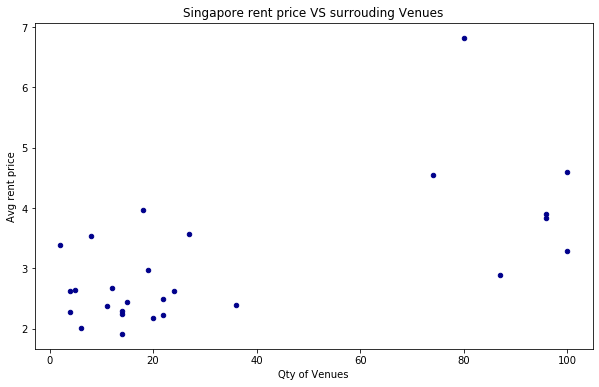

In [43]:
newresult.plot(kind='scatter', x='Venue', y='Avg/QT', figsize=(10, 6), color='darkblue')

plt.title('Singapore rent price VS surrouding Venues')
plt.xlabel('Qty of Venues')
plt.ylabel('Avg rent price')

plt.show()

In [44]:
newresult1 = newresult[['Neighborhood','Venue']]
newresult1.head()

,Neighborhood,Venue
0,"Anson, Tanjong Pagar",74
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",8
2,"Balestier, Toa Payoh, Serangoon",24
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",5
4,"Bishan, Ang Mo Kio",22


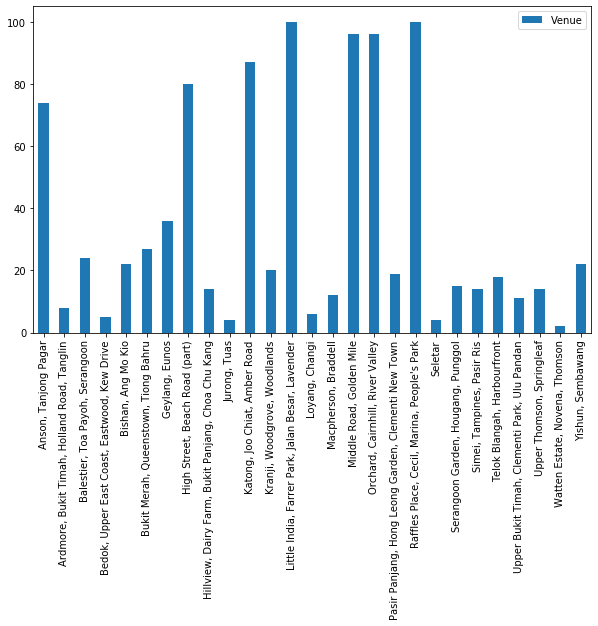

In [55]:
newresult1.plot(kind='bar', figsize=(10, 6), rot=90) 
x = newresult1['Neighborhood']
plt.xticks(range(27), x)
plt.xticks(rotation=90)
plt.show()

In [1]:
newresult.plot(kind='scatter', x='Avg/QT', y='Venue', figsize=(10, 6), color='darkblue')

plt.title('Singapore rent price VS surrouding Venues')
plt.xlabel('Qty of Venues')
plt.ylabel('Avg rent price')

plt.show()

NameError: name 'newresult' is not defined